# Outdated - see .py file

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy.integrate import quad
import camb
from scipy.optimize import brentq
from scipy.interpolate import CubicSpline

%matplotlib inline

In [2]:
# for plots
import seaborn as sns
sns.set_style("ticks", {'axes.grid': True, 'grid.linestyle': '--'})
sns.set_context("poster")
sns.set_palette("Set2")

In [3]:
# cosmology
pars = camb.CAMBparams()

In [4]:
# planck 2015 TT,TE,EE+lowP
# https://www.aanda.org/articles/aa/full_html/2016/10/aa25830-15/aa25830-15.html
pars.set_cosmology(ombh2=0.02225, 
                   omch2=0.1198,
                   cosmomc_theta=1.04077/100,
                   H0 = None,
                   tau = 0.079)

pars.InitPower.set_params(ns=0.9645,
                          As=2.207e-9)

pars.set_matter_power(redshifts=[0.0], kmax=10., nonlinear=False, k_per_logint=0)

#results
results = camb.get_results(pars)

In [5]:
h = results.hubble_parameter(0)/100

In [16]:
df = pd.DataFrame(np.ones((3,3)))

In [17]:
df

,0,1,2
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0


In [22]:
try:
    df.iloc[1,[1,2]] = 2, 3/0
except:
    df.iloc[1,[1,2]] = np.nan, np.nan

In [26]:
(df[1] + df[2])/2

0    1.0
1    NaN
2    1.0
dtype: float64

In [5]:
# use these two lines to compare with Planck derived parameters (Table 4 of 2015 parameters
# paper)
# results.get_derived_params()
# results.get_sigma8()

In [50]:
# linear matter power spectrum
kmin = 0.001
kmax = 10.
# multiplicative factors to make sure the region between kmin and kmax is properly interpolated
kh, z, [pk] = results.get_matter_power_spectrum(minkh=kmin*0.99, maxkh=kmax*1.001,npoints=1000)
k = kh*h
# creating a P(k) function by interpolating camb output
pk_func = interpolate.interp1d(k, pk, kind='cubic')

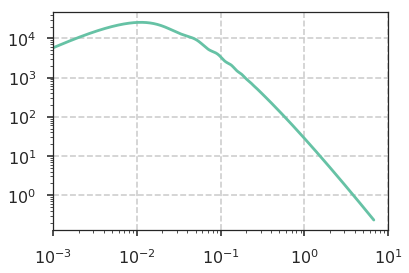

In [51]:
plt.loglog(k, pk_func(k))
plt.xlim(kmin,kmax)
plt.show()

In [52]:
# correlation function and its derivative given kmin, kmax and P(k)

# np.exp(-k**4) : smoothing kernel to regularize function for the transition k > 1

# correlation function
def xi(r,kmin=kmin,kmax=kmax,pk=pk_func):
    """Two point correlation function for r.
    - pars
    r: float, correlation scale in real space
    kmin, kmax: floats, min and max of k range
    pk: function object, power spectrum as function of k, P(k)
    - returns
    xi(r): float, value of correlation func at r"""
    # sin is omitted in the integrand because its being weighted in quad
    int_ = lambda k: np.exp(-k**4) * k**2 * pk(k)/(2*(np.pi**2)*k*r)
    xir =  quad(int_,kmin, kmax,weight='sin', wvar=r)
    return xir[0]

# first derivative of correlation function
def xi_r(r,kmin=kmin,kmax=kmax,pk=pk_func):
    """First derivative of two point correlation function.
    - pars
    r: float, correlation scale in real space
    kmin, kmax: floats, min and max of k range
    pk: function object, power spectrum as function of k, P(k)
    - returns
    xi_r(r): float, value of first derivative of correlation func at r"""
    # sin and cos are omitted in the integrand because they're being weighted in quad
    int_a = lambda k: k**2 * np.exp(-k**4) * pk(k)/(2*(np.pi**2)*r)
    int_b = lambda k: -1*k**2 * np.exp(-k**4) * pk(k)/(2*(np.pi**2)*k*r**2)
    xi_r_a =  quad(int_a,kmin, kmax,weight='cos', wvar=r)
    xi_r_b =  quad(int_b,kmin, kmax,weight='sin', wvar=r)
    return xi_r_a[0]+xi_r_b[0]

In [53]:
# dip and peak positions given first derivative of correlation function
def get_lp(xi_r, rmin=70., rmax=120., rsamples=8, root_dr = 3.):
    """Given first derivative of matter correlation function, get position of
    dip and peak.
    - pars
    xi_r: function object, first derivative of xi(r)
    rmin, rmax: floats, range to which look for roots
    rsamples: int, derivative sampled evenly in rsamples parts in range given
    root_dr: float, interval around each root to do a finer search with brentq
    - returns
    dip, peak: float, position of dip and peak of correlation function"""
    # sample derivative in rsamples points and interpolate
    r_list = np.linspace(rmin, rmax, rsamples)
    xi_r_list = [xi_r(r) for r in r_list]
    xi_r_interp = CubicSpline(r_list,xi_r_list, extrapolate=False)
    # find roots of interpolated function
    roots = xi_r_interp.roots(extrapolate=False)
    # defined region to look for each root in derivative
    ra=(roots[0]-root_dr,roots[0]+root_dr)
    rb=(roots[1]-root_dr,roots[1]+root_dr)
    # find each root and return
    dip = brentq(xi_r,*ra)
    peak = brentq(xi_r,*rb)
    return dip, peak

In [54]:
# Linear point position given first derivative of correlation function
def get_lp_old(xi_r, ra=(82.,90.), rb=(97.,105.)):
    """Given first derivative of matter correlation function, get position of
    dip and peak.
    - pars
    xi_r: function object, first derivative of xi(r)
    ra, rb: sets of floats, range of to look for dip and peak, respectively
    - returns
    lp: float, position of linear point"""
    dip = brentq(xi_r,*ra)
    peak = brentq(xi_r,*rb)
    return dip, peak

In [55]:
# Getting LP straigh from CAMB's results object

In [56]:
def get_pk_func(results,kmin,kmax):
    """Given cambs results object, calculate power spectrum as function of k.
    - pars
    results: camb's results object
    kmin, kmax: floats, limits in k space"""
    kh, z, [pk] = results.get_matter_power_spectrum(minkh=kmin*0.99,
                                                    maxkh=kmax*1.001,
                                                    npoints=500)
    return interpolate.interp1d(kh, pk, kind='cubic')

In [57]:
def lp_from_cosmo(results, kmin=0.001, kmax=100.):
    """Given cambs results object, calculate position of linear point.
    - pars
    results: camb's results object
    kmin, kmax: floats, limits in k space"""
    pk_func = get_pk_func(results, kmin, kmax)
    dxi_dr = lambda r: xi_r(r, kmin, kmax, pk_func)
    lp = get_lp(dxi_dr)
    return lp

In [58]:
from scipy.misc import derivative

In [69]:
xi(120,kmin*h,kmax*h)

0.000277988519860732

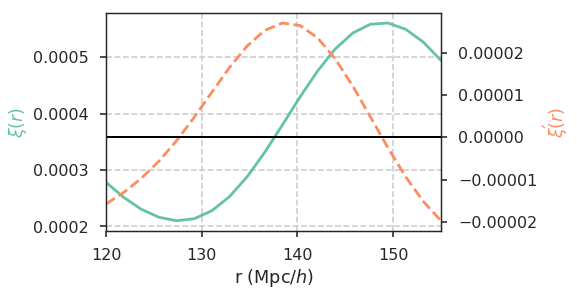

In [73]:
fig, ax1 = plt.subplots()

r = np.linspace(120,155,20)
xi_list = [xi(i,kmin*h,kmax*h) for i in r]
xi_r_list = [xi_r(i,kmin*h,kmax*h) for i in r]
### xi(r)


ax1.plot(r, xi_list)
ax1.set_xlim(r.min(),r.max())

ax1.set_ylabel(r'$\xi(r)$',color='C0')
ax1.set_xlabel(r'r (${\rm Mpc}/h$)')

### x'(r)
ax2 = ax1.twinx()
ax2.plot(r, xi_r_list,c='C1',ls='dashed')
#ax2.plot(r, derivative(xi,r),c='C2',ls='dotted',lw=10,alpha=0.5)
ax2.axhline(y=0,color='k',lw=2)
ax2.set_ylabel(r'$\xi\'(r)$',color='C1')
ax2.grid()
# plt.savefig('Figures/xi_r.png', dpi=300, bbox_inches='tight',
#            facecolor='w', edgecolor='w')


# linear point
# dip, peak = get_lp(xi_r)# Linear point position given first derivative of correlation function
# lp = (dip+peak)/2
# ax1.plot(lp,xi(lp),'s',color='magenta',alpha=0.5, label = 'LP')

ax1.legend()
plt.show()

In [41]:
lp/h

138.2279208032575

### Testing lp_from_pl func

In [5]:
lp_from_cosmo(results)

NameError: name 'lp_from_cosmo' is not defined

In [196]:
%%timeit
lp_from_cosmo(results)

1 loop, best of 3: 1.78 s per loop


In [6]:
import linear_point as lp

In [7]:
lp.lp_from_cosmo(results)

(85.85873876682864, 100.1343458368531)